# E-commerce

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. How many users do we have who made a purchase only once? 

2. How many orders per month, on average, are not delivered for various reasons (display details by reasons)? 

3. For each product, determine on which day of the week the product is most often bought. 

4. How many purchases does each user make on average per week (by months)? Do not forget that there may not be an integer number of weeks within a month. For example, November 2021 has 4.28 weeks. And within the metrics, this must be taken into account. 

5. Using pandas, conduct a cohort analysis of users. Between January and December, identify the cohort with the highest retention for the 3rd month. A description of the approach can be found here. 

6. Often for qualitative analysis of the audience I use approaches based on segmentation. Using python, build RFM user segmentation to qualitatively evaluate your audience. In clustering, you can choose the following metrics: R - time from the last purchase of the user to the current date, F - the total number of purchases from the user for all time, M - the amount of purchases for all time. Describe in detail how you created the clusters. For each RFM segment, plot the boundaries of the recency, frequency, and monetary metrics to interpret these clusters. An example of such a description: RFM-segment 132 (recency=1, frequency=3, monetary=2) has limits of recency metrics from 130 to 500 days, frequency from 2 to 5 orders per week, monetary from 1780 to 3560 rubles per week. A description of the approach can be found here.

To solve the problem, conduct a preliminary study of the data and formulate what should be considered a purchase. You can justify your choice with the help of payment facts, order statuses and other available data.

## Files:

### olist_customers_datase.csv - table with unique user IDs
- customer_id — per-custom user ID

- 7customer_unique_id - unique user ID (analogue of a passport number)

- customer_zip_code_prefix - user's zip code

- customer_city — user delivery city

- customer_state — user delivery state

### olist_orders_dataset.csv - table of orders
- order_id — unique order identifier (receipt number)

- customer_id — per-custom user ID

- order_status — order status

- order_purchase_timestamp - order creation time

- order_approved_at — order payment confirmation time

- order_delivered_carrier_date — time of transferring the order to the logistics service

- order_delivered_customer_date — order delivery time

- order_estimated_delivery_date - promised delivery date

### olist_order_items_dataset.csv — commodity items included in orders
- order_id — unique order identifier (receipt number)

- order_item_id - item identifier within one order

- product_id - product id (analogue of a barcode)

- seller_id - id of the product manufacturer

- shipping_limit_date — maximum delivery date by the seller to transfer the order to the logistics partner

- price — price per item

- freight_value - goods weight
- An example of a data structure can be visualized by order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Unique order statuses in the olist_orders_dataset table:

- created - created
- approved - confirmed
- invoiced - an invoice has been issued
- processing - in the process of order assembly
- shipped - shipped from the warehouse
- delivered - delivered to the user
- unavailable - unavailable
- canceled - canceled

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import timedelta
import datetime as dt
%matplotlib inline 
import calendar

import warnings
warnings.filterwarnings("ignore")

In [66]:
# table with unique user ids
customers = pd.read_csv('.\olist_customers_dataset.csv')
# order table
orders = pd.read_csv('.\olist_orders_dataset.csv', parse_dates=[3,4,5,6,7])
# commodity items included in orders
items = pd.read_csv('.\olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

# Task 1

How many users do we have who made a purchase only once?

In [67]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


In [68]:
orders.shape

(99441, 8)

In [69]:
# check data type 
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [70]:
# distribution of data in column orders_status
orders\
.order_status\
.value_counts(normalize=True)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64


**Note:**
In order to calculate the number of users, we combine the orders and customers tables

In [71]:
customers_orders = customers.merge(orders, on='customer_id')
customers_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06


Define users whose customer_unique_id contains one customer_id

In [72]:
one_customers = customers_orders \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'num_purchases'}) \
    .query('num_purchases == 1')

In [73]:
one_customers.head(2)

,customer_unique_id,num_purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1


In [74]:
one_customers.shape

(93099, 2)


Let's join two tables: one_customers and customers_orders. Let's leave only those users who are found in the one_customers table

In [75]:
customers_orders_once = one_customers.merge(customers_orders, on='customer_unique_id')
customers_orders_once.head(2)

,customer_unique_id,num_purchases,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0000366f3b9a7992bf8c76cfdf3221e2,1,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,SP,e22acc9c116caa3f2b7121bbb380d08e,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,4cb282e167ae9234755102258dd52ee8,6053,osasco,SP,3594e05a005ac4d06a72673270ef9ec9,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,2018-05-15


In [76]:
customers_orders_once.shape

(93099, 13)

In [77]:
#examination
customers_orders_once.num_purchases.max()

1

In [78]:

# Let's look at order_approved_at, for statuses where there are null values
customers_orders_once[customers_orders_once.order_approved_at.isna()].order_status.unique()

array(['canceled', 'created', 'delivered'], dtype=object)

In [79]:
# How many nanos are found in each status
customers_orders_once[customers_orders_once.order_approved_at.isna()].order_status.value_counts().unique()

array([79, 13,  4], dtype=int64)


**Note**
Most of the products have the delivered status. But there are missing order_approved_at values ​​even though the status is said to be delivered. If for status: canceled - this is relatively clear. That in the case of delivered - no. For convenience, these 14 delivered, I will not.


### Purchase
In this case, a purchase will be considered: purchases that were paid for (`order_approved_at.notna`) and `not canceled (!='canceled')`

In [80]:
answer = customers_orders_once[customers_orders_once.order_approved_at.notna()][customers_orders_once.order_status != "canceled"]

In [81]:
answer.shape[0]

92549

### Answer (task 1):
**92549 users** who made a purchase only once

# Task 2
### How many orders per month, on average, are not delivered for various reasons (display details by reasons)?

In [82]:
customers_orders.info() # checking data types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    99441 non-null  object        
 1   customer_unique_id             99441 non-null  object        
 2   customer_zip_code_prefix       99441 non-null  int64         
 3   customer_city                  99441 non-null  object        
 4   customer_state                 99441 non-null  object        
 5   order_id                       99441 non-null  object        
 6   order_status                   99441 non-null  object        
 7   order_purchase_timestamp       99441 non-null  datetime64[ns]
 8   order_approved_at              99281 non-null  datetime64[ns]
 9   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 10  order_delivered_customer_date  96476 non-null  datetime64[ns]
 11  order_estimated

In [83]:
# determine the number of missing values
customers_orders.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


**Note**
There are 2965 orders without a delivery date (order_delivered_customer_date) I'll try to "pull" this data

In [84]:
customers_orders['not_delivered'] = customers_orders.order_delivered_customer_date.isnull()

In [85]:
customers_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,not_delivered
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,False
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,False


In [86]:
customers_orders.shape

(99441, 13)

In [87]:
# filtering data 
not_delivered = customers_orders.query("not_delivered != False")

In [88]:
not_delivered.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,not_delivered
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaT,NaT,2018-04-09,True
47,c132855c926907970dcf6f2bf0b33a24,a8ae36a2bb6c2bbc3b5d62ede131c9ef,18740,taquarituba,SP,b5172d4a722c0ebb34c29bbbb7a3cb42,invoiced,2018-04-17 13:14:13,2018-04-18 05:31:51,NaT,NaT,2018-05-24,True


In [89]:
not_delivered.shape

(2965, 13)


### Let's study the distribution of delivery statuses by months

**Date:** expected delivery date `order_estimated_delivery_date`

In [90]:
not_del_month = not_delivered \
    .groupby(['order_status', 'order_estimated_delivery_date'], as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'purchases'})
not_del_month.head()

,order_status,order_estimated_delivery_date,purchases
0,approved,2017-03-01,1
1,approved,2017-05-22,1
2,canceled,2016-09-30,1
3,canceled,2016-10-24,1
4,canceled,2016-10-25,1


In [91]:
not_del_month['order_estimated_delivery_date'] = pd.to_datetime(not_del_month.order_estimated_delivery_date).dt.to_period('M').dt.to_timestamp()

In [92]:
not_del_month = not_del_month.rename(columns={'order_estimated_delivery_date':'date'})

In [93]:
not_del_month.head()

,order_status,date,purchases
0,approved,2017-03-01,1
1,approved,2017-05-01,1
2,canceled,2016-09-01,1
3,canceled,2016-10-01,1
4,canceled,2016-10-01,1


Calculate how many goods are not delivered per month on average (we consider both the average and the median)

Write to a new table result_1

In [94]:
result_1 = not_del_month \
    .groupby('date', as_index=False) \
    .agg(mean_purchases=('purchases','mean'), 
         median_purchases=('purchases','median')) \
    .sort_values('date', ascending=False)
result_1.head()

,date,mean_purchases,median_purchases
25,2018-11-01,1.000000,1.0
24,2018-10-01,1.200000,1.0
23,2018-09-01,2.523810,2.0
22,2018-08-01,3.041667,3.0
21,2018-07-01,2.139535,2.0


Calculate how many goods are not delivered per month on average for each status

We write the results in the table: detailed_res

In [95]:
detailed_res = not_del_month \
    .groupby(['date', 'order_status'], as_index=False) \
    .agg(mean_purchases=('purchases','mean'), 
         median_purchases=('purchases','median'))\
    .sort_values('date')
detailed_res

,date,order_status,mean_purchases,median_purchases
0,2016-09-01,canceled,1.000000,1.0
1,2016-10-01,canceled,1.000000,1.0
2,2016-10-01,shipped,1.000000,1.0
3,2016-11-01,canceled,2.000000,2.0
4,2016-11-01,invoiced,1.800000,2.0
...,...,...,...,...
112,2018-08-01,processing,1.000000,1.0
115,2018-09-01,canceled,2.722222,2.0
116,2018-09-01,shipped,1.333333,1.0
117,2018-10-01,canceled,1.200000,1.0


In [96]:
detailed_res["year_month"] = detailed_res["date"].dt.to_period("M")

In [97]:
detailed_res.head()

,date,order_status,mean_purchases,median_purchases,year_month
0,2016-09-01,canceled,1.0,1.0,2016-09
1,2016-10-01,canceled,1.0,1.0,2016-10
2,2016-10-01,shipped,1.0,1.0,2016-10
3,2016-11-01,canceled,2.0,2.0,2016-11
4,2016-11-01,invoiced,1.8,2.0,2016-11


In [98]:
sns.set(
    font_scale=1,
    style = 'whitegrid',
    rc = {'figure.figsize':(20,7)}
)

<Axes: title={'center': 'The average number of undelivered orders'}, xlabel='year_month', ylabel='mean_purchases'>

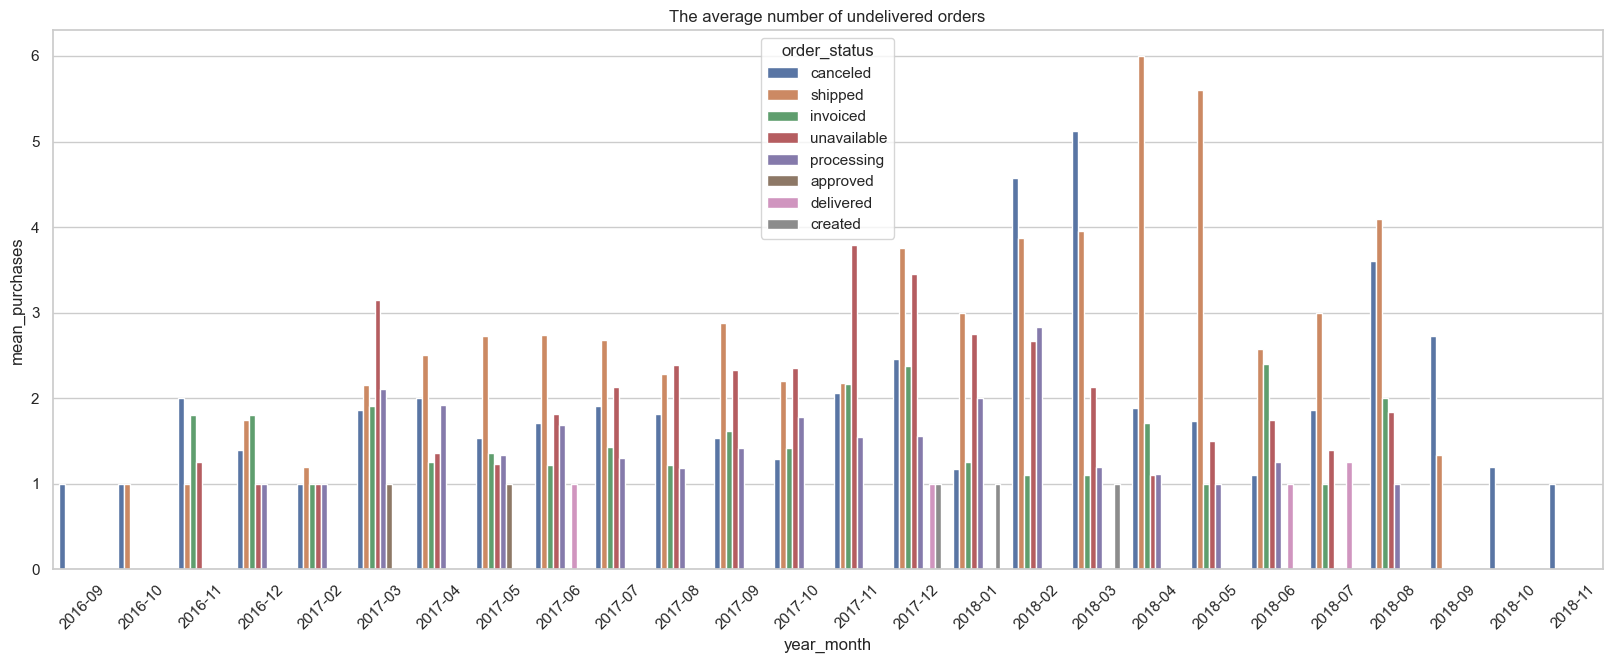

In [99]:
plt.xticks(rotation=45)
plt.title('The average number of undelivered orders')
plt.xlabel('Date')
plt.ylabel('Average number of orders')
sns.barplot(data=detailed_res, x="year_month", y="mean_purchases", hue="order_status")

In [100]:
detailed_res.order_status.value_counts()

canceled       26
shipped        23
invoiced       21
unavailable    21
processing     19
delivered       4
created         3
approved        2
Name: order_status, dtype: int64


There are canceled / unavailable orders There are also orders with the shipped status, and there are quite a lot of them. Other statuses are also presented. I can’t understand the reason, perhaps there are failures in the service

# Task 3
### For each product, determine on which day of the week the product is most often bought

Join tables: orders and items

In [101]:
orders_items = orders\
.merge(items, on='order_id', how='right')\
[['product_id','order_approved_at','order_status']]
orders_items.head()

,product_id,order_approved_at,order_status
0,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 09:45:35,delivered
1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 11:05:13,delivered
2,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:48:30,delivered
3,7634da152a4610f1595efa32f14722fc,2018-08-08 10:10:18,delivered
4,ac6c3623068f30de03045865e4e10089,2017-02-04 14:10:13,delivered


In [102]:
orders_items.isnull().sum()

product_id            0
order_approved_at    15
order_status          0
dtype: int64


**Note:** a purchase is what is paid for and not canceled

In [103]:
orders_items_1 = orders_items[orders_items.order_approved_at.notna()][orders_items.order_status != "canceled"]

In [104]:
orders_items_1.head()

,product_id,order_approved_at,order_status
0,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 09:45:35,delivered
1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 11:05:13,delivered
2,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:48:30,delivered
3,7634da152a4610f1595efa32f14722fc,2018-08-08 10:10:18,delivered
4,ac6c3623068f30de03045865e4e10089,2017-02-04 14:10:13,delivered


In [105]:

#Create a new column that will record the day of the week on which each item was purchased

orders_items_1['day'] = orders_items_1.order_approved_at.dt.day_name()

In [106]:
result_2 = orders_items_1\
.groupby(['product_id', 'day'], as_index=False)\
.agg(orders=('order_status', 'count'))\
.sort_values(['product_id', 'orders'], ascending=False)\
.groupby('product_id').head(1)

In [107]:
result_2

,product_id,day,orders
60798,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1
60797,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,3
60794,fff9553ac224cec9d15d49f5a263411f,Saturday,1
60793,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
60791,fff6177642830a9a94a0f2cba5e476d1,Monday,1
...,...,...,...
5,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1


In [108]:
result_2.orders.describe()

count    32732.000000
mean         1.686820
std          2.435898
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        119.000000
Name: orders, dtype: float64

In [109]:
result_2.sort_values('orders', ascending=False)

,product_id,day,orders
40854,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20038,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
15846,422879e10f46682990de24d770e7f83d,Tuesday,89
36366,99a4788cb24856965c36a24e339b6058,Tuesday,82
12998,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
37228,9cfb6da38dab3ad1f5e8cf3189ab6ae1,Sunday,1
37236,9cfca0dc6dd43d12b7de84a5e1e0a429,Wednesday,1
37237,9cfd1f36525a6b46d3e0b7f1e153fa4f,Saturday,1
37239,9d00d68952fff8f837706ac06d1b785b,Friday,1


# Task 4
 How many purchases does each user make on average per week (by months)? Do not forget that there may not be an integer number of weeks within a month. For example, November 2021 has 4.28 weeks. And within the metrics, this must be taken into account.

In [110]:
#Join tables customers and orders
cust_orders = customers.merge(orders, on='customer_id')
cust_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [111]:
# Formatting the payment date into the required format
cust_orders['order_approved_at '] = cust_orders['order_approved_at'].apply(pd.to_datetime)
cust_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-20 16:19:10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13 17:29:19
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29 10:10:09


In [112]:
# Formatting the date of purchase to the beginning of the month
cust_orders['order_approved_at'] = pd.to_datetime(cust_orders.order_approved_at).dt.to_period('M').dt.to_timestamp()
cust_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-01,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-01,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-01,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-20 16:19:10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-01,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13 17:29:19
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-01,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29 10:10:09


In [113]:
# filter the data
cust_orders_filtr = cust_orders[cust_orders.order_approved_at.notna()][cust_orders.order_status != "canceled"]
cust_orders_filtr.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-01,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-01,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-01,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-20 16:19:10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-01,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13 17:29:19
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-01,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29 10:10:09


In [114]:
# Number of purchases per user per month
purchases = cust_orders_filtr \
    .groupby(['customer_unique_id', 'order_approved_at'], as_index=False) \
    .agg({'customer_id':'count'}) \
    .rename(columns={'customer_id':'purchases'})
purchases.head()

,customer_unique_id,order_approved_at,purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1


In [115]:
purchases = purchases \
    .groupby(['customer_unique_id', 'order_approved_at'], as_index=False) \
    .agg({'purchases':'mean'}) \
    .rename(columns={'purchases':'mean_purchases'})
purchases.head()

,customer_unique_id,order_approved_at,mean_purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1.0
2,0000f46a3911fa3c0805444483337064,2017-03-01,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1.0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1.0


In [116]:
purchases['weeks'] = purchases.order_approved_at.apply(lambda x: x.days_in_month / 7)
purchases.head()

,customer_unique_id,order_approved_at,mean_purchases,weeks
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1.0,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1.0,4.428571
2,0000f46a3911fa3c0805444483337064,2017-03-01,1.0,4.428571
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1.0,4.428571
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1.0,4.285714


In [117]:
# Determine the number of purchases from each user on average per week (by months)
purchases['week_mounth'] = purchases.mean_purchases / purchases.weeks

In [118]:
# the average number of purchases per week (by months) is given below
purchases.head()

,customer_unique_id,order_approved_at,mean_purchases,weeks,week_mounth
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1.0,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1.0,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03-01,1.0,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1.0,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1.0,4.285714,0.233333


# Task 5
### Using pandas, perform a cohort analysis of users. Between January and December, identify the cohort with the highest retention for the 3rd month.

In [119]:
# combine two source tables
customers_orders_1 = customers.merge(orders, on='customer_id')
customers_orders_1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [120]:
customers_orders_1['order_purchase_timestamp'] = customers_orders_1['order_purchase_timestamp'].apply(pd.to_datetime)
customers_orders_1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [122]:
# grouping by order period
customers_orders_1['order_period'] = customers_orders_1.order_purchase_timestamp.apply(lambda x: x.strftime('%Y-%m'))
customers_orders_1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_period
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


In [123]:
# filtration
df_6 = customers_orders_1.query('order_purchase_timestamp > "2017-01-01" & order_period < "2017-12-01"')

In [124]:
# grouping by first purchase
df_6.set_index('customer_unique_id', inplace=True)
df_6['join_month'] = df_6.groupby(level=0)['order_purchase_timestamp'].min().apply(lambda x: x.strftime('%Y-%m')) 
df_6.reset_index(inplace=True)
df_6.insert(len(df_6.columns), 'TotalOrders', 0, allow_duplicates=False)
df_6.head()

,customer_unique_id,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_period,join_month,TotalOrders
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,2017-05,0
1,4c93744516667ad3b8f1fb645a3116a4,879864dab9bc3047522c92c82e1212b8,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,2017-09,2017-09,0
2,57b2a98a409812fe9618067b6b8ebe4f,5e274e7a0c3809e14aba7ad5aae0d407,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:29:02,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08,2017-11,2017-11,0
3,2a7745e1ed516b289ed9b29c7d0539a5,9fb35e4ed6f0a14a4977cd9aea4042bb,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 17:23:20,2017-11-27 18:01:20,2017-11-28 23:04:41,2017-12-08 22:16:17,2017-12-20,2017-11,2017-11,0
4,918dc87cd72cd9f6ed4bd442ed785235,b2d1536598b73a9abd18e0d75d92f0a3,18682,lencois paulista,SP,83d8f70418eefd96f37b483dff430305,delivered,2017-09-09 09:54:57,2017-09-09 10:10:17,2017-09-12 12:42:43,2017-09-20 20:23:34,2017-10-02,2017-09,2017-09,0


In [126]:
df_6 = df_6.rename(columns={"TotalOrders": "total_orders"})
df_6.head()

,customer_unique_id,order_purchase_timestamp,order_period,join_month,total_orders
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017-05,2017-05,0
1,4c93744516667ad3b8f1fb645a3116a4,2017-09-14 18:14:31,2017-09,2017-09,0
2,57b2a98a409812fe9618067b6b8ebe4f,2017-11-16 19:29:02,2017-11,2017-11,0
3,2a7745e1ed516b289ed9b29c7d0539a5,2017-11-27 17:23:20,2017-11,2017-11,0
4,918dc87cd72cd9f6ed4bd442ed785235,2017-09-09 09:54:57,2017-09,2017-09,0


In [127]:
groups = df_6.groupby(['join_month', 'order_period'])
# number of unique users, total number of orders, revenue for the period
cohorts = groups.agg({'customer_unique_id': pd.Series.nunique, 'total_orders': pd.Series.count})
cohorts.rename(columns={'customer_unique_id': 'total_users'}, inplace=True)
cohorts.head()

total_users  total_orders
join_month order_period                           
2017-01    2017-01               765           800
           2017-02                 3             3
           2017-03                 2             2
           2017-04                 1             1
           2017-05                 3             3

In [129]:
def cohort_period(df):
 df['cohort_period'] = np.arange(len(df)) + 1 # countdown from 1
 return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

total_users  total_orders  cohort_period
join_month order_period                                          
2017-01    2017-01               765           800              1
           2017-02                 3             3              2
           2017-03                 2             2              3
           2017-04                 1             1              4
           2017-05                 3             3              5

In [130]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['join_month', 'cohort_period'], inplace=True)

In [131]:
# create a series containing the size of each JoinMonth cohort
cohort_group_size = cohorts['total_users'].groupby(level=1).first()
cohort_group_size.head()

cohort_period
1    765
2      3
3      2
4      1
5      3
Name: total_users, dtype: int64

In [132]:
cohorts['total_users'].head()

join_month  cohort_period
2017-01     1                765
            2                  3
            3                  2
            4                  1
            5                  3
Name: total_users, dtype: int64

In [133]:
cohorts['total_users'].unstack(1)

cohort_period,1,2,3,4,5,6,7,8,9,10,11
join_month,,,,,,,,,,,
2017-01,765.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,3.0,1.0
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN
2017-04,2353.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,NaN,NaN,NaN,NaN
2017-07,3895.0,20.0,14.0,10.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN
2017-08,4184.0,29.0,14.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4131.0,28.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)#transposed by simply swapping join_month and cohort_period and then adding axis=1
cohorts.set_index(['join_month','cohort_period'], inplace=True)
#a series containing the size of each cohort join_month
cohort_group_size = cohorts['total_users'].groupby(level=0).first()
cohorts['total_users'].unstack(0)
user_retention = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention[['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08' , '2017-09', '2017-10', '2017-11', '2017-12']]

join_month,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_period,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.003922,0.002283,0.004932,0.005950,0.005006,0.004779,0.005135,0.006931,0.006778,0.006935,0.005476,NaN
3,0.002614,0.002854,0.003794,0.002125,0.005006,0.003504,0.003594,0.003346,0.005326,0.002461,NaN,NaN
4,0.001307,0.001142,0.003794,0.001700,0.003893,0.004141,0.002567,0.002629,0.002905,NaN,NaN,NaN
5,0.003922,0.003995,0.003414,0.003400,0.003059,0.002549,0.002824,0.003585,NaN,NaN,NaN,NaN
6,0.001307,0.001142,0.001517,0.002550,0.003337,0.003823,0.002054,NaN,NaN,NaN,NaN,NaN
7,0.005229,0.002283,0.001517,0.003400,0.004171,0.003823,NaN,NaN,NaN,NaN,NaN,NaN
8,0.001307,0.001712,0.003035,0.002975,0.001669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.001307,0.001712,0.003414,0.002975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Task 5 (var 2)

In [135]:
df = customers.merge(orders, on='customer_id')
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [136]:
df_cust = df.loc[:, ['customer_unique_id', 'order_approved_at', 'order_status']] # select required columns
df_cust.head() 

,customer_unique_id,order_approved_at,order_status
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,delivered
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,delivered
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10,delivered
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,delivered
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09,delivered


In [137]:
df_cust = df_cust[df_cust.order_approved_at.notna()][df_cust.order_status != "canceled"]
df_cust.head()

,customer_unique_id,order_approved_at,order_status
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,delivered
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,delivered
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10,delivered
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,delivered
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09,delivered


In [138]:
df_cust.dtypes

customer_unique_id            object
order_approved_at     datetime64[ns]
order_status                  object
dtype: object

In [139]:
df_cust["order_approved_at_months"] = df_cust.order_approved_at.apply(lambda x : x.strftime('%Y-%m'))           
# dt.to_period("M")
df_cust.head(2)

,customer_unique_id,order_approved_at,order_status,order_approved_at_months
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,delivered,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,delivered,2018-01


In [140]:
df_cust = df_cust.query(('"2016-12" < order_approved_at_months < "2018-04"'))
df_cust.head(2)

,customer_unique_id,order_approved_at,order_status,order_approved_at_months
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,delivered,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,delivered,2018-01


In [141]:
# Determine in which month each user made their first purchase
first_time = df_cust\
    .groupby('customer_unique_id', as_index = False)\
    .agg({'order_approved_at_months': 'min'})\
    .rename(columns = ({'order_approved_at_months' : 'first_purchase_date'}))
first_time.head()

,customer_unique_id,first_purchase_date
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,00053a61a98854899e70ed204dd4bafe,2018-02
4,0005e1862207bf6ccc02e4228effd9a0,2017-03


In [142]:
# Combine data about the month of the first purchase to a table with data about customers and orders
cus_first = df_cust.merge(first_time, how = 'inner', on = 'customer_unique_id')
cus_first.head()

,customer_unique_id,order_approved_at,order_status,order_approved_at_months,first_purchase_date
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,delivered,2017-05,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,delivered,2018-01,2018-01
2,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,delivered,2018-03,2018-03
3,4c93744516667ad3b8f1fb645a3116a4,2017-09-14 18:25:11,delivered,2017-09,2017-09
4,4c93744516667ad3b8f1fb645a3116a4,2017-10-15 13:05:29,delivered,2017-10,2017-09


In [143]:
cus_first.dtypes

customer_unique_id                  object
order_approved_at           datetime64[ns]
order_status                        object
order_approved_at_months            object
first_purchase_date                 object
dtype: object

In [144]:
# Converting the column with dates order_approved_at_months, first_purchase_date to datetime format
cus_first['order_approved_at_months'] = pd.to_datetime(cus_first.order_approved_at_months)
cus_first['first_purchase_date'] = pd.to_datetime(cus_first.first_purchase_date)
cus_first.dtypes

customer_unique_id                  object
order_approved_at           datetime64[ns]
order_status                        object
order_approved_at_months    datetime64[ns]
first_purchase_date         datetime64[ns]
dtype: object

In [145]:
# new column: difference between purchase date (order_approved_at_months) and first purchase date (first_purchase_date)
cus_first['diff'] = cus_first.order_approved_at_months - cus_first.first_purchase_date
cus_first.head()

,customer_unique_id,order_approved_at,order_status,order_approved_at_months,first_purchase_date,diff
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,delivered,2017-05-01,2017-05-01,0 days
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,delivered,2018-01-01,2018-01-01,0 days
2,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,delivered,2018-03-01,2018-03-01,0 days
3,4c93744516667ad3b8f1fb645a3116a4,2017-09-14 18:25:11,delivered,2017-09-01,2017-09-01,0 days
4,4c93744516667ad3b8f1fb645a3116a4,2017-10-15 13:05:29,delivered,2017-10-01,2017-09-01,30 days


In [146]:
# Purchases made in the 3rd month after the first purchase
third_month = cus_first.loc[cus_first['diff'] <= '92 days'].loc[cus_first['diff'] >= '89 days']
third_month.head()

,customer_unique_id,order_approved_at,order_status,order_approved_at_months,first_purchase_date,diff
435,4e65032f1f574189fb793bac5a867bbc,2017-06-02 09:50:10,delivered,2017-06-01,2017-03-01,92 days
436,4e65032f1f574189fb793bac5a867bbc,2017-06-24 17:00:07,delivered,2017-06-01,2017-03-01,92 days
823,39104edef5e46d7b8c61848cc95e6d97,2017-10-01 10:24:04,delivered,2017-10-01,2017-07-01,92 days
949,25f24493ded5ebebc26a69b5db344e35,2018-02-26 09:50:00,delivered,2018-02-01,2017-11-01,92 days
997,b8b3c435a58aebd788a477bed8342910,2017-08-24 10:35:22,delivered,2017-08-01,2017-05-01,92 days


In [147]:
# Cohort with number of purchases
cohorts = third_month\
    .groupby(['first_purchase_date','diff'], as_index = False)\
    .agg({'customer_unique_id':'count'})\
    .rename(columns = ({'customer_unique_id' : 'third_month_count'}))
cohorts

,first_purchase_date,diff,third_month_count
0,2017-01-01,90 days,1
1,2017-02-01,89 days,3
2,2017-03-01,92 days,11
3,2017-04-01,91 days,5
4,2017-05-01,92 days,14
5,2017-06-01,92 days,13
6,2017-07-01,92 days,8
7,2017-08-01,92 days,11
8,2017-09-01,91 days,18
9,2017-10-01,92 days,4


In [148]:
# Let's form cohorts with the number of first purchases
first_month_customers = cus_first\
    .groupby('first_purchase_date', as_index = False)\
    .agg({'customer_unique_id' : 'count'})\
    .rename(columns = ({'customer_unique_id' : 'first_month_count'}))
first_month_customers.head()

,first_purchase_date,first_month_count
0,2017-01-01,789
1,2017-02-01,1792
2,2017-03-01,2742
3,2017-04-01,2414
4,2017-05-01,3779


In [149]:
# records of first purchases in 2017
first_month_2017 = first_month_customers.query('"2016-12" < first_purchase_date < "2018-01"').reset_index(drop = True)
first_month_2017

,first_purchase_date,first_month_count
0,2017-01-01,789
1,2017-02-01,1792
2,2017-03-01,2742
3,2017-04-01,2414
4,2017-05-01,3779
5,2017-06-01,3280
6,2017-07-01,3984
7,2017-08-01,4382
8,2017-09-01,4314
9,2017-10-01,4543


In [150]:
# merge tables with cohorts into one
res = first_month_2017.merge(cohorts, how = 'inner', on = 'first_purchase_date')
res

,first_purchase_date,first_month_count,diff,third_month_count
0,2017-01-01,789,90 days,1
1,2017-02-01,1792,89 days,3
2,2017-03-01,2742,92 days,11
3,2017-04-01,2414,91 days,5
4,2017-05-01,3779,92 days,14
5,2017-06-01,3280,92 days,13
6,2017-07-01,3984,92 days,8
7,2017-08-01,4382,92 days,11
8,2017-09-01,4314,91 days,18
9,2017-10-01,4543,92 days,4


In [151]:
res['retention'] = round(100 * res.third_month_count / res.first_month_count, 2)
res

,first_purchase_date,first_month_count,diff,third_month_count,retention
0,2017-01-01,789,90 days,1,0.13
1,2017-02-01,1792,89 days,3,0.17
2,2017-03-01,2742,92 days,11,0.40
3,2017-04-01,2414,91 days,5,0.21
4,2017-05-01,3779,92 days,14,0.37
5,2017-06-01,3280,92 days,13,0.40
6,2017-07-01,3984,92 days,8,0.20
7,2017-08-01,4382,92 days,11,0.25
8,2017-09-01,4314,91 days,18,0.42
9,2017-10-01,4543,92 days,4,0.09


In [152]:
res.retention.max()

0.42

### Answer (task 5)
The cohort with the highest retention for the 3rd month - users who made their first purchase in September 2017, their retention is 0.42%. The rate is quite low. But if you remember the first task, then we had a lot of buyers who made a purchase only once

# Task 6
### Often I use approaches based on segmentation for qualitative analysis of the audience. Using python, build RFM user segmentation to qualitatively evaluate your audience. In clustering, you can choose the following metrics: R - time from the last purchase of the user to the current date, F - the total number of purchases from the user for all time, M - the amount of purchases for all time. Describe in detail how you created the clusters. For each RFM segment, plot the boundaries of the recency, frequency, and monetary metrics to interpret these clusters.

In [153]:
customer_with_order = customers.merge(orders, on='customer_id')
customer_with_order.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06


In [154]:
df_orders_items = customer_with_order.merge(items[['order_id', 'order_item_id', 'product_id', 'price']], on='order_id', how='left')
df_orders_items.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,price
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1.0,a9516a079e37a9c9c36b9b78b10169e8,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1.0,4aa6014eceb682077f9dc4bffebc05b0,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1.0,bd07b66896d6f1494f5b86251848ced7,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1.0,a5647c44af977b148e0a3a4751a09e2e,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1.0,9391a573abe00141c56e38d84d7d5b3b,230.00


In [155]:
df_cut = df_orders_items.loc[:, ['customer_unique_id', 'order_id', 'order_approved_at', 'order_status', 'price']]
df_cut.head()

,customer_unique_id,order_id,order_approved_at,order_status,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,delivered,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,delivered,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19,delivered,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 10:10:09,delivered,230.00


In [156]:
df_cut_filter = df_cut[(df_cut['order_approved_at'] > "2016-12-31") & (df_cut['order_approved_at'] < '2018-01-01')]
df_cut_filter.head()

,customer_unique_id,order_id,order_approved_at,order_status,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99
5,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,delivered,259.90
7,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,delivered,19.90
10,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,delivered,25.30
12,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,delivered,99.00


In [157]:
# Add a column with the date of the last purchase. The principle of what a "purchase" is is taken the same as in the first question of the project.

last_order = df_cut_filter \
    .query('order_approved_at != "" and order_status != ["canceled"]') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_approved_at': 'max'}) \
    .rename(columns={'order_approved_at': 'last_order'})
last_order

,customer_unique_id,last_order
0,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17
2,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52
3,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:43:26
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18 09:30:22
...,...,...
43395,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12-27 22:47:44
43396,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:15:16
43397,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:16:20
43398,ffff371b4d645b6ecea244b27531430a,2017-02-07 16:02:44


In [158]:
df_with_last = df_cut_filter.merge(last_order[['customer_unique_id', 'last_order']], on='customer_unique_id', how='left')
df_with_last.head()

,customer_unique_id,order_id,order_approved_at,order_status,price,last_order
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99,2017-05-16 15:22:12
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,delivered,259.90,2017-10-15 13:05:29
2,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,delivered,19.90,2017-11-16 19:55:41
3,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,delivered,25.30,2017-11-27 18:01:20
4,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,delivered,99.00,2017-09-09 10:10:17


In [159]:
# Add a column with the number of elapsed days from the last order to the present 01/20/23 2:13

df_with_last['days_last_order'] = ((pd.Timestamp.now().normalize() - df_with_last.last_order).dt.days).astype('Int64')
df_with_last.head()

,customer_unique_id,order_id,order_approved_at,order_status,price,last_order,days_last_order
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99,2017-05-16 15:22:12,2229
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,delivered,259.90,2017-10-15 13:05:29,2077
2,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,delivered,19.90,2017-11-16 19:55:41,2045
3,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,delivered,25.30,2017-11-27 18:01:20,2034
4,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,delivered,99.00,2017-09-09 10:10:17,2113


In [160]:
# Total number of purchases per user

total_purchases = df_with_last \
    .query('order_approved_at != "" and order_status != ["canceled"]') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id': 'nunique'}) \
    .rename(columns={'order_id': 'total_purchases'}) \
    .sort_values('total_purchases', ascending=False)
total_purchases.head()

,customer_unique_id,total_purchases
23908,8d50f5eadf50201ccdcedfb9e2ac8455,10
3262,12f5d6e1cbf93dafd9dcc19095df0b3d,6
4665,1b6c7548a2a1f9037c1fd3ddfed95f33,5
17087,6469f99c1f9dfae7733b25662e7f1782,5
12214,47c1a3033b8b77b3ab6e109eb4d5fdf3,5


In [161]:
total_purchases.shape

(43400, 2)

In [162]:
df_with_last_total = df_with_last.merge(total_purchases[['customer_unique_id', 'total_purchases']], on='customer_unique_id', how='left')

df_with_last_total.head()

,customer_unique_id,order_id,order_approved_at,order_status,price,last_order,days_last_order,total_purchases
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99,2017-05-16 15:22:12,2229,1.0
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,delivered,259.90,2017-10-15 13:05:29,2077,2.0
2,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,delivered,19.90,2017-11-16 19:55:41,2045,1.0
3,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,delivered,25.30,2017-11-27 18:01:20,2034,1.0
4,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,delivered,99.00,2017-09-09 10:10:17,2113,1.0


In [163]:
df_with_last_total.dtypes

customer_unique_id            object
order_id                      object
order_approved_at     datetime64[ns]
order_status                  object
price                        float64
last_order            datetime64[ns]
days_last_order                Int64
total_purchases              float64
dtype: object

In [164]:
df_with_last_total.total_purchases = df_with_last_total.total_purchases.astype('Int32')

In [165]:
df_with_last_total.isna().sum()

customer_unique_id      0
order_id                0
order_approved_at       0
order_status            0
price                 465
last_order            243
days_last_order       243
total_purchases       243
dtype: int64

In [166]:
df_with_last_total.dropna(subset=['total_purchases'], inplace=True)

In [167]:
df_with_last_total.dropna(subset=['price'], inplace=True)

In [168]:
df_with_last_total.isna().sum()

customer_unique_id    0
order_id              0
order_approved_at     0
order_status          0
price                 0
last_order            0
days_last_order       0
total_purchases       0
dtype: int64

In [169]:
df_with_last_total.order_status.unique()

array(['delivered', 'shipped', 'invoiced', 'processing', 'approved',
       'canceled'], dtype=object)

In [170]:
df_with_last_total = df_with_last_total[df_with_last_total['order_status'] != "canceled"]

In [171]:
# Add the last column with the amount of purchases, before doing clustering.

total_revenue = df_with_last_total \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'price': 'sum'}) \
    .rename(columns={'price': 'total_revenue'}) \
    .sort_values('total_revenue', ascending=False)
total_revenue.head()

,customer_unique_id,total_revenue
1727,0a0a92112bd4c708ca5fde585afaa872,13440.0
36680,da122df9eeddfedc1dc1f5349a1a690c,7388.0
37050,dc4802a71eae9be1dd28f5d788ceb526,6735.0
42822,ff4159b92c40ebe40454e3e6a7c35ed6,6499.0
10765,4007669dec559734d6f53e029e360987,5934.6


In [172]:

df_with_last_total = df_with_last_total.merge(total_revenue[['customer_unique_id', 'total_revenue']], on='customer_unique_id', how='left')
df_with_last_total.head()

,customer_unique_id,order_id,order_approved_at,order_status,price,last_order,days_last_order,total_purchases,total_revenue
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99,2017-05-16 15:22:12,2229,1,124.99
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,delivered,259.90,2017-10-15 13:05:29,2077,2,506.52
2,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,delivered,19.90,2017-11-16 19:55:41,2045,1,19.90
3,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,delivered,25.30,2017-11-27 18:01:20,2034,1,25.30
4,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,delivered,99.00,2017-09-09 10:10:17,2113,1,99.00


In [173]:
rfm = df_with_last_total # create a new variable (for convenience)

To conduct an RFM analysis, I define the parameters: recency (R), frequency (F), monetary (M).

The following will fit the task:

- R - time from the user's last purchase to the current date

- F - the total number of purchases from the user for the entire time

- M - amount of purchases for all time

In [174]:
rfm_1 = rfm.rename(columns={'days_last_order': 'recency', 'total_purchases': 'frequency', 'total_revenue': 'monetary'})
rfm_1.head()

,customer_unique_id,order_id,order_approved_at,order_status,price,last_order,recency,frequency,monetary
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99,2017-05-16 15:22:12,2229,1,124.99
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,delivered,259.90,2017-10-15 13:05:29,2077,2,506.52
2,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,delivered,19.90,2017-11-16 19:55:41,2045,1,19.90
3,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,delivered,25.30,2017-11-27 18:01:20,2034,1,25.30
4,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,delivered,99.00,2017-09-09 10:10:17,2113,1,99.00


<Axes: xlabel='recency', ylabel='Count'>

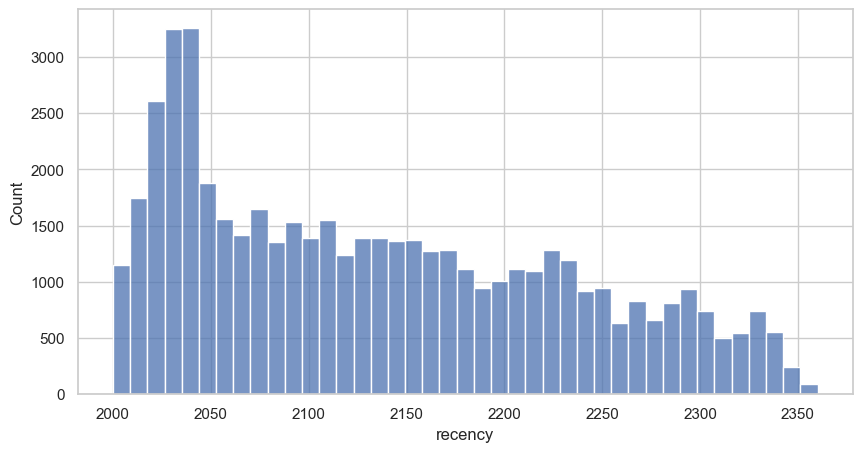

In [180]:
plt.figure(figsize=(10, 5))
sns.histplot(rfm_1.recency) # distribution of "recency" is not normal

<Axes: xlabel='monetary', ylabel='Count'>

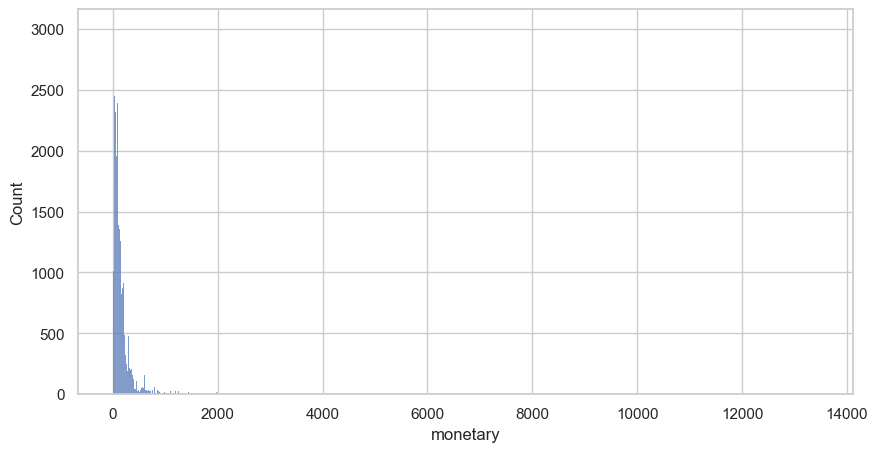

In [181]:
plt.figure(figsize=(10, 5))
sns.histplot(rfm_1.monetary) #distribution of parameter "monetary" is even "worse"

<Axes: xlabel='frequency', ylabel='Count'>

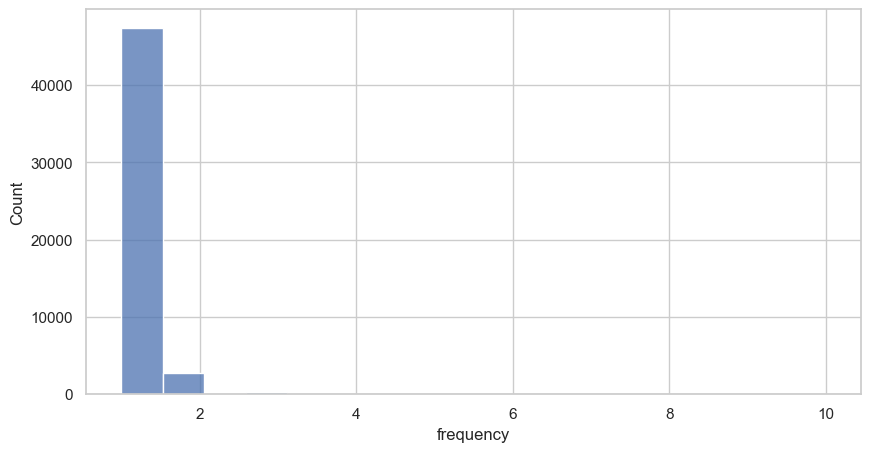

In [182]:
plt.figure(figsize=(10, 5))
sns.histplot(rfm_1.frequency)

In [183]:
rfm_1.frequency.value_counts()

1     47458
2      2695
3       275
4        69
5        29
10        9
6         6
Name: frequency, dtype: Int64

In [184]:
# Distribution of the "frequency" parameter

rfm_1.frequency.value_counts(normalize=True)

1        0.939
2     0.053323
3     0.005441
4     0.001365
5     0.000574
10    0.000178
6     0.000119
Name: frequency, dtype: Float64


**Note:** In the "frequency" parameter, most of the users made only one purchase

In [185]:
rfm_1['r_score'] = pd.qcut(rfm_1.recency, 3)
rfm_1.r_score

0          (2176.0, 2360.0]
1          (2070.0, 2176.0]
2        (1999.999, 2070.0]
3        (1999.999, 2070.0]
4          (2070.0, 2176.0]
                ...        
50536      (2176.0, 2360.0]
50537      (2176.0, 2360.0]
50538    (1999.999, 2070.0]
50539    (1999.999, 2070.0]
50540    (1999.999, 2070.0]
Name: r_score, Length: 50541, dtype: category
Categories (3, interval[float64, right]): [(1999.999, 2070.0] < (2070.0, 2176.0] < (2176.0, 2360.0]]

In [186]:
rfm_1['r_score'] = pd.qcut(rfm_1.recency, 3, labels=[3,2,1])

In [187]:
rfm_1['m_score'] = pd.qcut(rfm_1.monetary, 3)
rfm_1.m_score

0          (59.94, 139.8]
1        (139.8, 13440.0]
2          (2.289, 59.94]
3          (2.289, 59.94]
4          (59.94, 139.8]
               ...       
50536      (59.94, 139.8]
50537      (2.289, 59.94]
50538      (2.289, 59.94]
50539    (139.8, 13440.0]
50540      (2.289, 59.94]
Name: m_score, Length: 50541, dtype: category
Categories (3, interval[float64, right]): [(2.289, 59.94] < (59.94, 139.8] < (139.8, 13440.0]]

In [188]:
rfm_1['m_score'] = pd.qcut(rfm_1.monetary, 3, labels=[1,2,3])
rfm_1.m_score

0        2
1        3
2        1
3        1
4        2
        ..
50536    2
50537    1
50538    1
50539    3
50540    1
Name: m_score, Length: 50541, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [189]:
rfm_1['f_score'] = pd.cut(rfm_1.frequency, [0,1,2,np.inf])
rfm_1.f_score

0        (0.0, 1.0]
1        (1.0, 2.0]
2        (0.0, 1.0]
3        (0.0, 1.0]
4        (0.0, 1.0]
            ...    
50536    (0.0, 1.0]
50537    (0.0, 1.0]
50538    (0.0, 1.0]
50539    (0.0, 1.0]
50540    (0.0, 1.0]
Name: f_score, Length: 50541, dtype: category
Categories (3, interval[float64, right]): [(0.0, 1.0] < (1.0, 2.0] < (2.0, inf]]

In [190]:
rfm_1['f_score'] = pd.cut(rfm_1.frequency, [0,1,2,np.inf], labels=[1,2,3])
rfm_1.f_score

0        1
1        2
2        1
3        1
4        1
        ..
50536    1
50537    1
50538    1
50539    1
50540    1
Name: f_score, Length: 50541, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [191]:
rfm_1 = rfm_1[['customer_unique_id','r_score','f_score','m_score', 'recency', 'frequency', 'monetary' ]].drop_duplicates()

In [192]:
rfm_1['score_int'] = rfm_1['r_score'].astype(int) + rfm_1['f_score'].astype(int) + rfm_1['m_score'].astype(int)

In [193]:
rfm_1['score'] = rfm_1['r_score'].astype(str) + rfm_1['f_score'].astype(str) + rfm_1['m_score'].astype(str)

In [194]:
rfm_1.sort_values('score_int', ascending=False)

,customer_unique_id,r_score,f_score,m_score,recency,frequency,monetary,score_int,score
7215,da2b78576894a7f95d45bfd20250cc54,3,3,3,2027,3,374.15,9,333
4574,9947c0ed8bf41cd508a78da36abc1d41,3,3,3,2067,3,149.50,9,333
6952,e12f7f1e96f1f9f6361572028a1fad5a,3,3,3,2062,3,679.70,9,333
11167,b59e4bb4efe81ba0f7d30cff6734f9a2,3,3,3,2027,3,250.62,9,333
38871,e30b83af13d6ff0b0f427b2a67c43b39,3,3,3,2028,3,763.40,9,333
...,...,...,...,...,...,...,...,...,...
35308,c0955a0a7cd0cbaf66ee32b50d136132,1,1,1,2237,1,47.90,3,111
46056,57953ff2a999a79ace45303decbc6245,1,1,1,2298,1,46.99,3,111
4110,7b8b31516cdb407eaed1ce4f2d30c448,1,1,1,2187,1,31.90,3,111
28947,6e279371383dfb449436fd7edd27e803,1,1,1,2271,1,13.99,3,111


In [196]:
seg_map = {
    r'333': 'VIP',
    r'33[1-2]': 'Favorable',
    r'32[1-3]': 'Potentially profitable',
    r'31[1-3]': 'Newbies',
    r'23[1-3]': 'Sleepers profitable',
    r'22[2-3]': 'Sleepers profitable',
    r'21[1-3]': 'Sleepers',
    r'221': 'Sleepers',
    r'13[2-3]': 'Exit profitable',
    r'12[2-3]': ' Leaving',
    r'131': 'Leaving',
    r'11[1-3]': 'Lost',
    r'121': 'Lost'
}

In [197]:
rfm_1['segment'] = rfm_1['score'].replace(seg_map, regex=True)
rfm_1.head()

,customer_unique_id,r_score,f_score,m_score,recency,frequency,monetary,score_int,score,segment
0,861eff4711a542e4b93843c6dd7febb0,1,1,2,2229,1,124.99,4,112,Lost
1,4c93744516667ad3b8f1fb645a3116a4,2,2,3,2077,2,506.52,7,223,Sleepers profitable
2,57b2a98a409812fe9618067b6b8ebe4f,3,1,1,2045,1,19.90,5,311,Newbies
3,2a7745e1ed516b289ed9b29c7d0539a5,3,1,1,2034,1,25.30,5,311,Newbies
4,918dc87cd72cd9f6ed4bd442ed785235,2,1,2,2113,1,99.00,5,212,Sleepers


In [198]:
rfm_1.segment.value_counts()

Lost                      14191
Sleepers                  13864
Newbies                   13742
Sleepers profitable         425
Potentially profitable      408
 Leaving                    276
VIP                          28
Exit profitable              19
Leaving                       6
Favorable                     1
Name: segment, dtype: int64

In [199]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatch

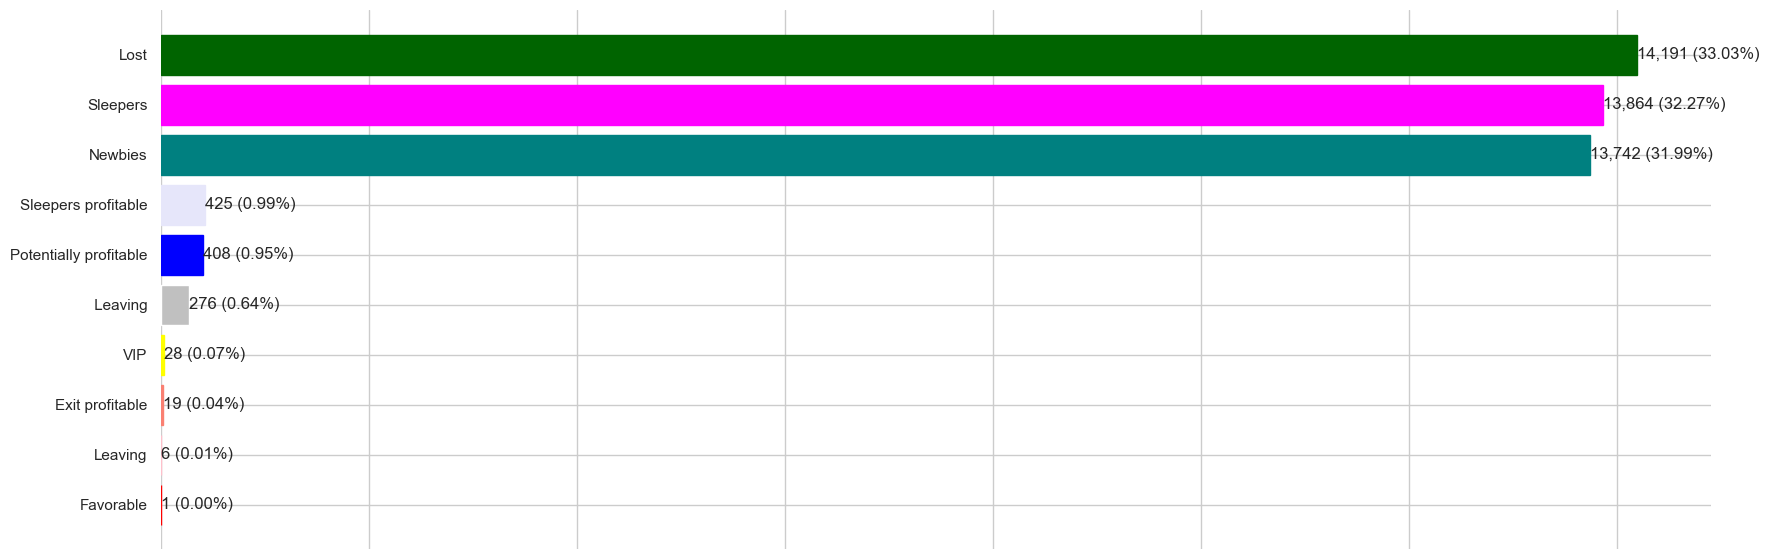

In [204]:
segments = rfm_1['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments)),
              segments,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments)))
ax.set_yticklabels(segments.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments.index[i] in ['VIP']:
            bar.set_color('yellow')
        elif segments.index[i] == 'Favorable':
            bar.set_color('red')
        elif segments.index[i] == 'Potentially profitable':
            bar.set_color('blue')
        elif segments.index[i] == 'Newbies':
            bar.set_color('teal')
        elif segments.index[i] == 'Sleepers profitable':
            bar.set_color('lavender')
        elif segments.index[i] == 'Sleepers':
            bar.set_color('magenta')
        elif segments.index[i] == 'Exit profitable':
            bar.set_color('salmon')
        elif segments.index[i] == 'Leaving':
            bar.set_color('pink')
        elif segments.index[i] == 'Lost':
            bar.set_color('darkgreen')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:.2f}%)'.format(int(value),
                                   float(value*100/segments.sum())),
                va='center',
                ha='left'
               )

plt.show()

Based on the barplot, we can see that the general part (~ 30-33%) of our users is in the following categories:

- lost (33%)
- sleeping (32.27)
- brand new (31.99)
I don't know anything about what's for sale. Possibly special items. Which do not have to be "frequently" bought

Many clients have been lost. There is an option that the advertising campaign is either not set up, or the strategy is bad.

Also for sale you can sell: a quality product. Or like a service? Can be found on dormant profitable and dangerous risks

**possible options:**

- discount for new customers on the second purchase
- bonus system: loyalty program
- set up product recommendations if the problem is in the service, then you need to identify this problem, for example, set up feedback so that the client evaluates the quality of the order and the quality of delivery of the order; clients. The ad comes in the mail.